In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['प्रभाकर',
 'जालिंदर',
 'अविंनाश',
 'निर्थला',
 'दिपाली',
 'शीतल',
 'उल्हास',
 'लक्ष्मी']

In [3]:
len(words)

34916

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(len(chars))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

63
{1: 'ँ', 2: 'ं', 3: 'अ', 4: 'आ', 5: 'इ', 6: 'ई', 7: 'उ', 8: 'ऊ', 9: 'ए', 10: 'ऐ', 11: 'ऑ', 12: 'ओ', 13: 'औ', 14: 'क', 15: 'ख', 16: 'ग', 17: 'घ', 18: 'च', 19: 'छ', 20: 'ज', 21: 'झ', 22: 'ञ', 23: 'ट', 24: 'ठ', 25: 'ड', 26: 'ढ', 27: 'ण', 28: 'त', 29: 'थ', 30: 'द', 31: 'ध', 32: 'न', 33: 'प', 34: 'फ', 35: 'ब', 36: 'भ', 37: 'म', 38: 'य', 39: 'र', 40: 'ऱ', 41: 'ल', 42: 'ळ', 43: 'व', 44: 'श', 45: 'ष', 46: 'स', 47: 'ह', 48: '़', 49: 'ा', 50: 'ि', 51: 'ी', 52: 'ु', 53: 'ू', 54: 'ृ', 55: 'ॅ', 56: 'े', 57: 'ै', 58: 'ॉ', 59: 'ो', 60: 'ौ', 61: '्', 62: '॑', 63: '॒', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:3]:
  
  print(w)
  context = [0] * block_size
  print(context)
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

प्रभाकर
[0, 0, 0]
... ---> प
..प ---> ्
.प् ---> र
प्र ---> भ
्रभ ---> ा
रभा ---> क
भाक ---> र
ाकर ---> .
जालिंदर
[0, 0, 0]
... ---> ज
..ज ---> ा
.जा ---> ल
जाल ---> ि
ालि ---> ं
लिं ---> द
िंद ---> र
ंदर ---> .
अविंनाश
[0, 0, 0]
... ---> अ
..अ ---> व
.अव ---> ि
अवि ---> ं
विं ---> न
िंन ---> ा
ंना ---> श
नाश ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([24, 3]), torch.int64, torch.Size([24]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([218524, 3]) torch.Size([218524])
torch.Size([27351, 3]) torch.Size([27351])
torch.Size([27351, 3]) torch.Size([27351])


In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((64, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 64), generator=g)
b2 = torch.randn(64, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

19704

In [10]:
for p in parameters:
  p.requires_grad = True

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []
Xtr.shape

torch.Size([218524, 3])

In [12]:
temp = torch.randint(0, Xtr.shape[0], (32,))
Xtr[temp].shape

torch.Size([32, 3])

In [45]:
for i in range(20):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.7085444927215576


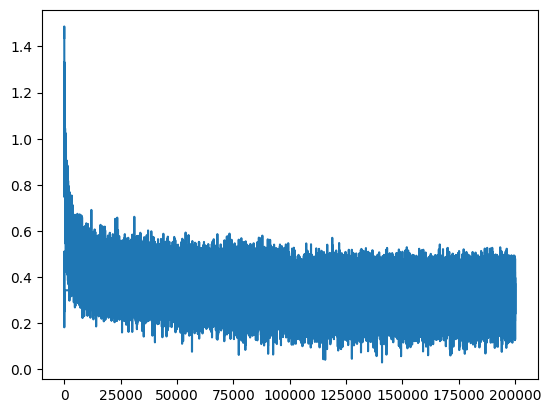

In [27]:
plt.plot(stepi, lossi)

In [46]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2612, grad_fn=<NllLossBackward0>)

In [47]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3164, grad_fn=<NllLossBackward0>)

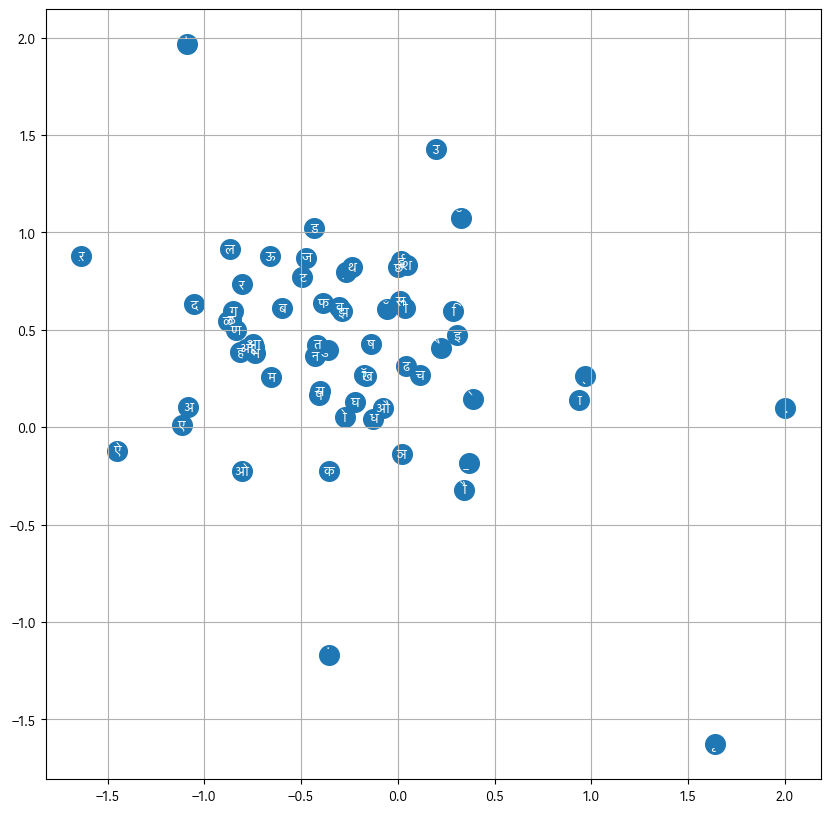

In [53]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Option 1: Temporarily set font family
plt.rcParams['font.family'] = 'Kohinoor Devanagari'

plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [54]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [79]:

# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

मधुदर्श.
दिग.
गुस्मर.
तालाड.
मिनी.
भायव.
पुन्थ.
मुरौाई.
अनिकिणाथी.
तुळक्ष्मण.
